# Looking at new architecture for cnn, trying Xception

## Jan 2021

In [1]:
# conventional import
import numpy as np
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})
import pdb
import PIL
from PIL import Image

# tf imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.constraints import max_norm

# sk imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_distances

# from py files
from src.cnn_new import Autoencoder


In [2]:
class XceptionAE(Autoencoder):
    def __init__(self, gray_imgs=True):
        super().__init__(gray_imgs=gray_imgs)
        self._clear_variables()

    def build_autoencoder(self, init_num_filters, num_encode_layers, enc_do=0.5, dec_do=0.5, max_norm_value=2, kernel_size=(3,3)):
        '''
        Functional API build of model
        input shape = (128,128,x) where x=1,3 1=greyscale
        num encode/decode layers = 5

        128 init layers --> 5 encoding layers for 128 feats

        '''
        self.init_num_filters = init_num_filters
        self.num_encode_layers = num_encode_layers
        self.kernel_size = kernel_size

        if self.gray_imgs:
            inputs = keras.Input(shape=(128,128,1))
            out_filter = 1
        else:
            inputs = keras.Input(shape=(128,128,3))
            out_filter = 3
            
        layer_list = []
        for encode_layer in range(num_encode_layers)[::-1]:
            if encode_layer == max(range(num_encode_layers)):
                layer_list.append(
                    layers.SeparableConv2D(
                        filters=(init_num_filters // (2**encode_layer)),
                        kernel_size=kernel_size,
                        padding='same'
                    )(inputs)
                )
                
                layer_list.append(
                    layers.BatchNormalization()(layer_list[-1])
                )

                layer_list.append(
                    layers.Activation('relu')(layer_list[-1])
                )

                layer_list.append(
                    layers.SeparableConv2D(
                        filters=(init_num_filters // (2**encode_layer)),
                        kernel_size=kernel_size,
                        padding='same'
                    )(layer_list[-1])
                )

                layer_list.append(
                    layers.BatchNormalization()(layer_list[-1])
                )

                layer_list.append(
                    layers.Activation('relu')(layer_list[-1])
                )

                layer_list.append(
                    layers.MaxPooling2D(
                        pool_size=2,
                        padding='same'
                    )(layer_list[-1])
                )

            else:
                layer_list.append(
                    layers.SeparableConv2D(
                        filters=(init_num_filters // (2**encode_layer)),
                        kernel_size=kernel_size,
                        padding='same'
                    )(layer_list[-1])
                )
                
                layer_list.append(
                    layers.BatchNormalization()(layer_list[-1])
                )

                layer_list.append(
                    layers.Activation('relu')(layer_list[-1])
                )

                layer_list.append(
                    layers.SeparableConv2D(
                        filters=(init_num_filters // (2**encode_layer)),
                        kernel_size=kernel_size,
                        padding='same'
                    )(layer_list[-1])
                )

                layer_list.append(
                    layers.BatchNormalization()(layer_list[-1])
                )

                layer_list.append(
                    layers.Activation('relu')(layer_list[-1])
                )

                layer_list.append(
                    layers.MaxPooling2D(
                        pool_size=2,
                        padding='same'
                    )(layer_list[-1])
                )

        layer_list.append(
            layers.Flatten()(layer_list[-1])
        )

        self.encoder = keras.Model(inputs, layer_list[-1])


        resize_side = int(128/(2**num_encode_layers))
        resize_layers = int(init_num_filters)

        layer_list.append(
            layers.Reshape(
                target_shape=(resize_side,resize_side,resize_layers)
            )(layer_list[-1])
        )

        for decode_layer in range(num_encode_layers):
            layer_list.append(
                layers.Conv2DTranspose(
                    filters=(init_num_filters // (2**decode_layer)),
                    kernel_size=kernel_size,
                    padding='same'
                )(layer_list[-1])
            )

            layer_list.append(
                layers.BatchNormalization()(layer_list[-1])
            )

            layer_list.append(
                layers.Activation('relu')(layer_list[-1])
            )

            layer_list.append(
                layers.Conv2DTranspose(
                    filters=(init_num_filters // (2**decode_layer)),
                    kernel_size=kernel_size,
                    padding='same'
                )(layer_list[-1])
            )
            
            layer_list.append(
                layers.BatchNormalization()(layer_list[-1])
            )

            layer_list.append(
                layers.Activation('relu')(layer_list[-1])
            )

            layer_list.append(
                layers.UpSampling2D(
                    size=(2,2)
                )(layer_list[-1])
            )


        layer_list.append(
            layers.Conv2DTranspose(
                    filters=out_filter,
                    kernel_size=kernel_size,
                    padding='same',
                    activation='sigmoid'
            )(layer_list[-1])
        )

        self.autoencoder = keras.Model(inputs, layer_list[-1])
        self.autoencoder.compile(
            optimizer='adam',
            loss='mean_squared_error'
        )

In [3]:
target_size=128
color_mode="rgb"
test_dir='data/proc_images/from_sandbox/{}/{}/test'.format(color_mode, target_size)
validation_dir='data/proc_images/from_sandbox/{}/{}/validation'.format(color_mode, target_size)

In [4]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.20,
    height_shift_range=0.20
)

val_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = train_datagen.flow_from_directory(
    'data/listing_images/full/test/',
    target_size=(target_size, target_size),
    color_mode=color_mode,
    class_mode='input'
)

Found 7780 images belonging to 1 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    'data/listing_images/full/validation/',
    target_size=(target_size, target_size),
    color_mode=color_mode,
    class_mode='input'
)

Found 1944 images belonging to 1 classes.


In [22]:
model_builder = XceptionAE(gray_imgs=False)

init_filters = 128
encode_layers = 5

model_builder.build_autoencoder(init_filters, encode_layers)
model = model_builder.autoencoder
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
separable_conv2d_30 (Separab (None, 128, 128, 8)       59        
_________________________________________________________________
batch_normalization_v2_60 (B (None, 128, 128, 8)       32        
_________________________________________________________________
activation_60 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
separable_conv2d_31 (Separab (None, 128, 128, 8)       144       
_________________________________________________________________
batch_normalization_v2_61 (B (None, 128, 128, 8)       32        
_________________________________________________________________
activation_61 (Activation)   (None, 128, 128, 8)       0   

In [26]:
my_earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    restore_best_weights=True
)

ckpoint_dir = 'data/model_ckpoints/'
ckpoint_name = 'Xception_{}_{}'.format(init_filters, encode_layers)

my_checkpoints_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpoint_dir + ckpoint_name + '{epoch}-{val_loss}.hdf5',
    monitor='val_loss',
    save_best_only=True
)

In [28]:
history = model.fit(
    x = train_generator,
    epochs = 50,
    callbacks = [my_earlystopping_cb, my_checkpoints_cb],
    steps_per_epoch=(7780 // 32) + 1,
    validation_data=val_generator,
    validation_steps= (1944 // 32) +1,
    use_multiprocessing=True
)

Epoch 1/50
244/244 [==============================] - 216s 886ms/step - loss: 0.0189 - val_loss: 0.0243
Epoch 2/50
244/244 [==============================] - 221s 906ms/step - loss: 0.0167 - val_loss: 0.0234
Epoch 3/50
244/244 [==============================] - 219s 899ms/step - loss: 0.0156 - val_loss: 0.0245
Epoch 4/50
244/244 [==============================] - 222s 909ms/step - loss: 0.0148 - val_loss: 0.0219
Epoch 5/50
244/244 [==============================] - 221s 906ms/step - loss: 0.0142 - val_loss: 0.0210
Epoch 6/50
244/244 [==============================] - 219s 899ms/step - loss: 0.0137 - val_loss: 0.0212
Epoch 7/50
244/244 [==============================] - 221s 906ms/step - loss: 0.0133 - val_loss: 0.0206
Epoch 8/50
244/244 [==============================] - 222s 912ms/step - loss: 0.0130 - val_loss: 0.0201
Epoch 9/50
244/244 [==============================] - 221s 904ms/step - loss: 0.0127 - val_loss: 0.0184
Epoch 10/50
244/244 [==============================] - 221s 905m

In [29]:
history_2 = history

In [31]:
len(history_1.history['val_loss'])

11

In [33]:
type(history_2.history['val_loss'])

list

In [34]:
history_1.history['val_loss'].extend(history_2.history['val_loss'])

In [39]:
val_loss = history_1.history['val_loss']

In [30]:
import matplotlib.pyplot as plt

In [41]:
len(val_loss)

42

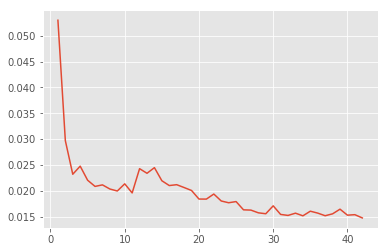

In [46]:
fig, ax = plt.subplots()

x_vals = np.linspace(1,len(val_loss), len(val_loss))
ax.plot(x_vals,val_loss)

In [10]:
model_builder = Autoencoder(gray_imgs=False)

init_filters = 128
encode_layers = 5

model_builder.build_autoencoder(init_filters, encode_layers)
model = model_builder.autoencoder
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
spatial_dropout2d_10 (Spatia (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d_11 (Spatia (None, 32, 32, 16)        0   

In [7]:
my_earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    restore_best_weights=True
)

model_name = 'Autoencoder'

ckpoint_dir = 'data/model_ckpoints/'
ckpoint_name = '{}_{}_{}_'.format(model_name, init_filters, encode_layers)

my_checkpoints_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpoint_dir + ckpoint_name + '{epoch}-{val_loss}.hdf5',
    monitor='val_loss',
    save_best_only=True
)

In [11]:
history = model.fit(
    x = train_generator,
    epochs = 50,
    callbacks = [my_earlystopping_cb, my_checkpoints_cb],
    steps_per_epoch=(7780 // 32) + 1,
    validation_data=val_generator,
    validation_steps= (1944 // 32) +1,
    use_multiprocessing=True
)

Epoch 1/50
244/244 [==============================] - 172s 706ms/step - loss: 0.0488 - val_loss: 0.0506
Epoch 2/50
244/244 [==============================] - 156s 640ms/step - loss: 0.0463 - val_loss: 0.0493
Epoch 3/50
244/244 [==============================] - 153s 628ms/step - loss: 0.0448 - val_loss: 0.0470
Epoch 4/50
244/244 [==============================] - 164s 673ms/step - loss: 0.0423 - val_loss: 0.0433
Epoch 5/50
244/244 [==============================] - 148s 605ms/step - loss: 0.0403 - val_loss: 0.0393
Epoch 6/50
244/244 [==============================] - 148s 605ms/step - loss: 0.0386 - val_loss: 0.0377
Epoch 7/50
244/244 [==============================] - 149s 609ms/step - loss: 0.0380 - val_loss: 0.0365
Epoch 8/50
244/244 [==============================] - 146s 597ms/step - loss: 0.0370 - val_loss: 0.0365
Epoch 9/50
244/244 [==============================] - 157s 642ms/step - loss: 0.0364 - val_loss: 0.0350
Epoch 10/50
244/244 [==============================] - 162s 666m

In [14]:
history_fname = ckpoint_dir + ckpoint_name + 'history.pkl'
with open(history_fname, 'wb') as f:
    pickle.dump(history.history, f)

In [17]:
model_builder = XceptionAE(gray_imgs=False)

init_filters = 128
encode_layers = 5

model_builder.build_autoencoder(init_filters, encode_layers)
model = model_builder.autoencoder
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
separable_conv2d_10 (Separab (None, 128, 128, 8)       59        
_________________________________________________________________
batch_normalization_v2_20 (B (None, 128, 128, 8)       32        
_________________________________________________________________
activation_20 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
separable_conv2d_11 (Separab (None, 128, 128, 8)       144       
_________________________________________________________________
batch_normalization_v2_21 (B (None, 128, 128, 8)       32        
_________________________________________________________________
activation_21 (Activation)   (None, 128, 128, 8)       0   

In [19]:
my_earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    restore_best_weights=True
)

model_name = 'Xception_real'

ckpoint_dir = 'data/model_ckpoints/'
ckpoint_name = '{}_{}_{}_'.format(model_name, init_filters, encode_layers)

my_checkpoints_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpoint_dir + ckpoint_name + '{epoch}-{val_loss:0.4f}.hdf5',
    monitor='val_loss',
    save_best_only=True
)

In [20]:
history = model.fit(
    x = train_generator,
    epochs = 50,
    callbacks = [my_earlystopping_cb, my_checkpoints_cb],
    steps_per_epoch=(7780 // 32) + 1,
    validation_data=val_generator,
    validation_steps= (1944 // 32) +1,
    use_multiprocessing=True
)

Epoch 1/50
244/244 [==============================] - 246s 1s/step - loss: 0.0320 - val_loss: 0.0610
Epoch 2/50
244/244 [==============================] - 235s 961ms/step - loss: 0.0210 - val_loss: 0.0298
Epoch 3/50
244/244 [==============================] - 232s 951ms/step - loss: 0.0188 - val_loss: 0.0274
Epoch 4/50
244/244 [==============================] - 235s 962ms/step - loss: 0.0172 - val_loss: 0.0260
Epoch 5/50
244/244 [==============================] - 235s 963ms/step - loss: 0.0162 - val_loss: 0.0257
Epoch 6/50
244/244 [==============================] - 235s 964ms/step - loss: 0.0151 - val_loss: 0.0277
Epoch 7/50
244/244 [==============================] - 411s 2s/step - loss: 0.0145 - val_loss: 0.0230
Epoch 8/50
244/244 [==============================] - 342s 1s/step - loss: 0.0139 - val_loss: 0.0200
Epoch 9/50
244/244 [==============================] - 311s 1s/step - loss: 0.0135 - val_loss: 0.0191
Epoch 10/50
244/244 [==============================] - 331s 1s/step - loss: 

In [21]:
history_fname = ckpoint_dir + ckpoint_name + 'history.pkl'
with open(history_fname, 'wb') as f:
    pickle.dump(history.history, f)

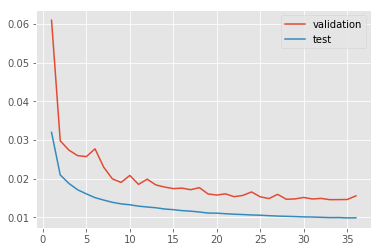

In [24]:
fig, ax = plt.subplots()

val_loss = history.history['val_loss']

x_vals = np.linspace(1,len(val_loss), len(val_loss))
ax.plot(x_vals,val_loss, label='validation')
ax.plot(x_vals, history.history['loss'], label='test')
ax.legend()

In [25]:
model_name = 'Xception'
old_ckpoint_name = '{}_{}_{}'.format(model_name, init_filters, encode_layers)

old_history_fname = ckpoint_dir + old_ckpoint_name + 'history.pkl'
with open(old_history_fname, 'rb') as f:
    old_history = pickle.load(f)

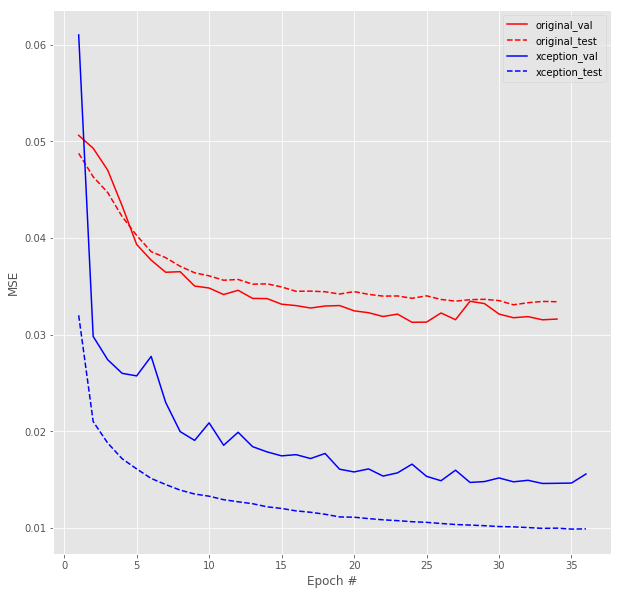

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

old_xvals = np.linspace(1, len(old_history['val_loss']), len(old_history['val_loss']))

ax.plot(old_xvals, old_history['val_loss'], c='r', label='original_val')
ax.plot(old_xvals, old_history['loss'], c='r', ls='--', label='original_test')
ax.plot(x_vals,val_loss, c='b', label='xception_val')
ax.plot(x_vals, history.history['loss'], c='b', ls='--', label='xception_test')
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch #')
ax.legend()

In [29]:
plt.rcParams.update({'font.size':18})

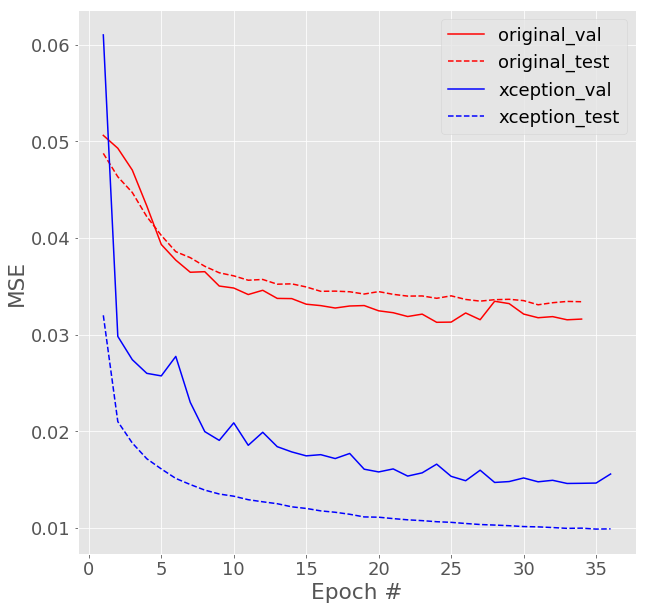

In [36]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10,10))

old_xvals = np.linspace(1, len(old_history['val_loss']), len(old_history['val_loss']))

ax.plot(old_xvals, old_history['val_loss'], c='r', label='original_val')
ax.plot(old_xvals, old_history['loss'], c='r', ls='--', label='original_test')
ax.plot(x_vals,val_loss, c='b', label='xception_val')
ax.plot(x_vals, history.history['loss'], c='b', ls='--', label='xception_test')
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch #')
ax.set_title('xception vs original ae\nFeb ')
ax.legend()
plt.savefig('images/xception_vs_original.png', dpi=150)

In [35]:
plt.savefig('images/xception_vs_original.png', dpi=150)

<Figure size 432x288 with 0 Axes>